In [1]:
import sys
sys.path.append('../src')

from m4_generator import M4Generator
from error_functions import *
from visualization import *
from evaluation import evaluate_model
from utils import save_model, load_model

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers


import numpy as np
import keras
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline

Using TensorFlow backend.


In [2]:
EPOCHS = 1
BATCH_SIZE = 50
LOOKBACK = 48
HORIZON = 48

gen = M4Generator("../Dataset/Train/Hourly-train.csv", "../Dataset/Test/Hourly-test.csv",
                  LOOKBACK, HORIZON, BATCH_SIZE)

model = Sequential()


model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, LOOKBACK, 1),  return_sequences=True, activation='tanh',
              kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)))

model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, LOOKBACK,1), return_sequences=True, activation='tanh',
              kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)))

model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, LOOKBACK,1),  activation='tanh',
              kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)))

model.add(Dense(HORIZON, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3)))

opt = optimizers.RMSprop(lr=0.001)#, clipvalue=0.3)
#opt = optimizers.SGD(lr=0.01, decay=1e-2, momentum=0.7, nesterov=True)

model.compile(loss='mae', optimizer=opt)
#model.compile(loss=smapetf, optimizer=opt)

hist = model.fit_generator(gen, steps_per_epoch= gen.__len__(), epochs=EPOCHS)

save_model(model, "../models/model.json", "../models/model.h5")


Epoch 1/1
137/137 [==============================] - 28s 203ms/step - loss: 0.1606
Saved model to disk


In [4]:
train_x, train_y, test_x, test_y = gen.get_data()

loaded_model = load_model("../models/model.json", "../models/model.h5")

error = evaluate_model(loaded_model, test_x, test_y, smapetf)
print(error)
error = evaluate_model(loaded_model, train_x, train_y, smapetf)
print(error)

Loaded model from disk
57.77272055008536
12.31692522130073


Loaded model from disk
(50, 48, 1)
float32
float32
(50,)


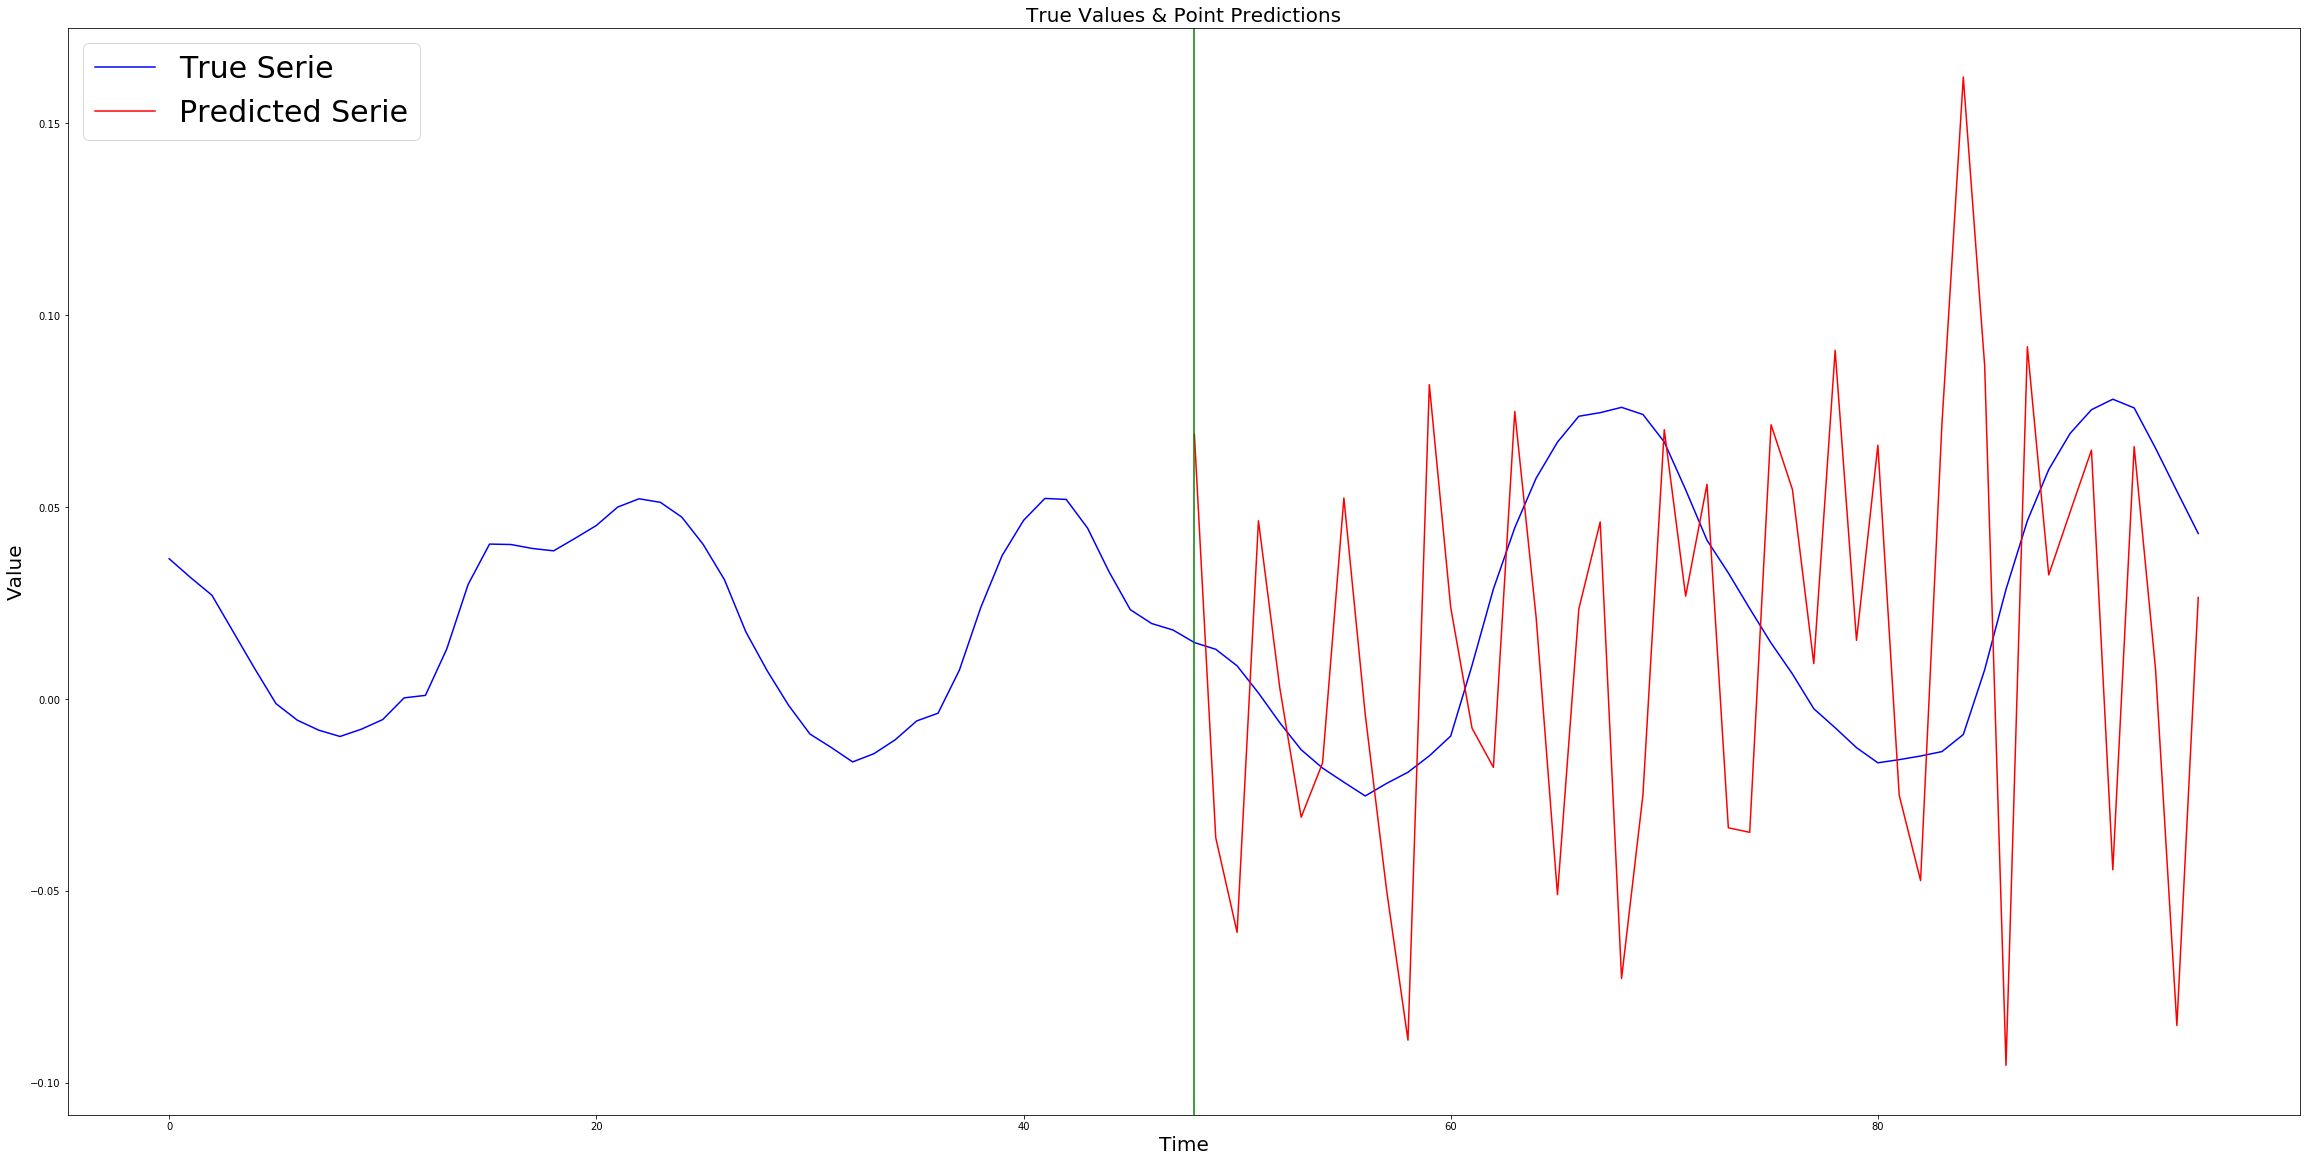

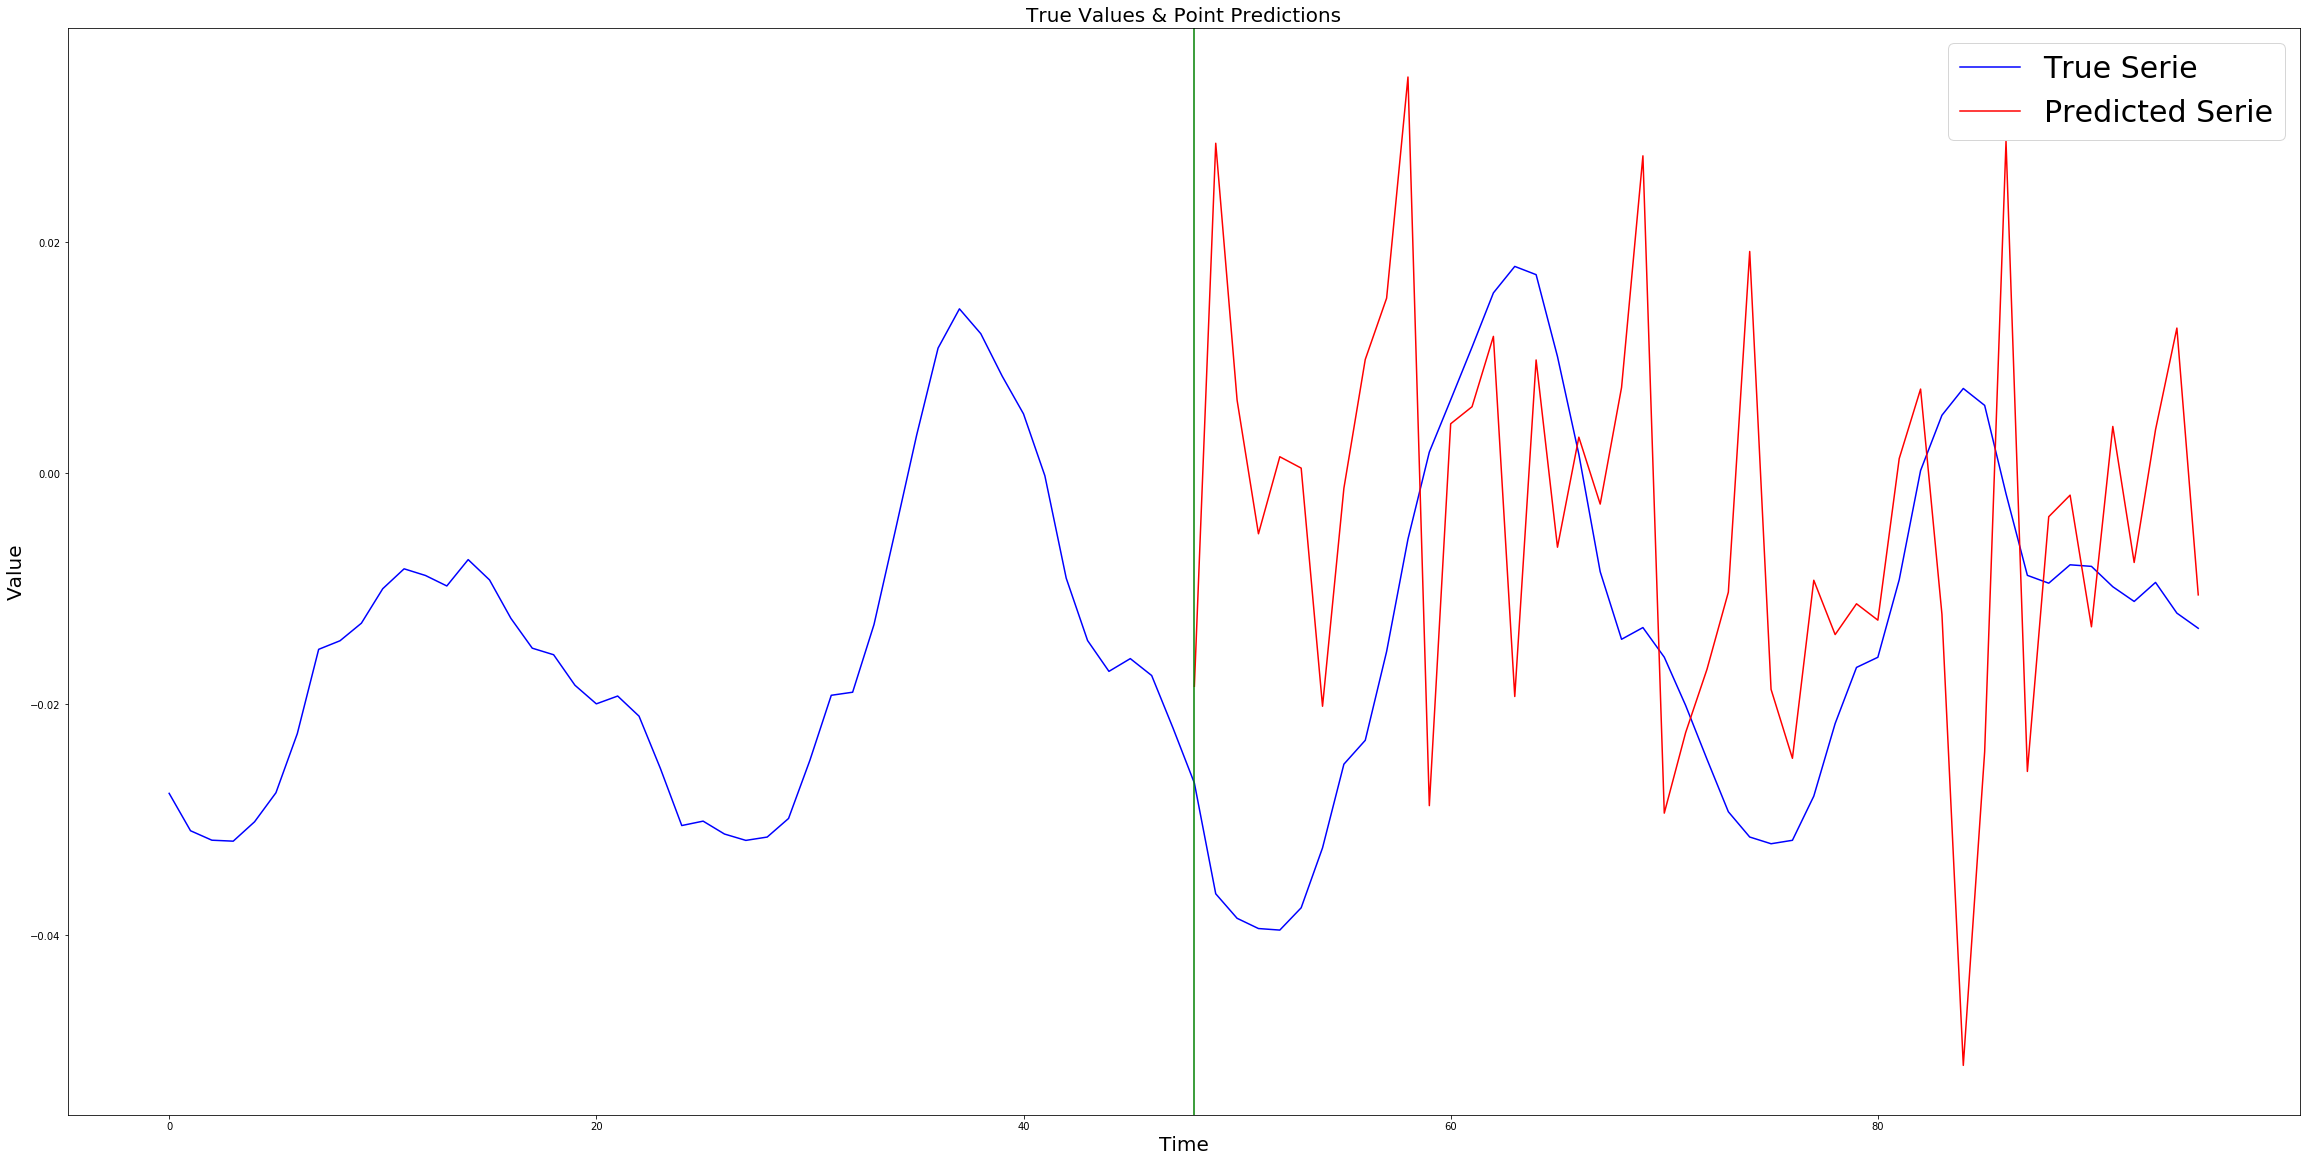

In [9]:
train_x, train_y, test_x, test_y = gen.get_data()



#============ Predict Train
predictedY = loaded_model.predict(train_x[:BATCH_SIZE,:].reshape(BATCH_SIZE, LOOKBACK, 1), batch_size = BATCH_SIZE)

#plot_series(train_x, train_y, predictedY)
plot_serie_and_prediction(train_x, train_y, predictedY, serie_indx=19)

#============ Predict Test
predictedY = loaded_model.predict(test_x[:BATCH_SIZE,:].reshape(BATCH_SIZE, LOOKBACK, 1), batch_size = BATCH_SIZE)

#plot_series(test_x, test_y, predictedY, series_num=10)
plot_serie_and_prediction(test_x, test_y, predictedY, serie_indx=19)